In [1]:
import pandas as pd
from seaborn import xkcd_palette
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np

In [3]:
# Read the scaled data
data = pd.read_csv("scaled_flood_drivers_dataset.csv")

# Define categories and their columns
categories = {
    "Labels": [col for col in data.columns if col.startswith('L')],
    "Topography": [col for col in data.columns if col.startswith('T')],
    "Hydrological": [col for col in data.columns if col.startswith('H')],
    "Vegetation": [col for col in data.columns if col.startswith('V')],
    "Shape": [col for col in data.columns if col.startswith('S')],
    "Climate": [col for col in data.columns if col.startswith('C')]
}
data.head()


,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,C2,H2,H3,H4,H5,T5,H9,H10,H11,H12
0,0.005477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008500,...,0.060988,0.547630,0.612131,0.521886,0.037818,0.298928,0.039498,0.529595,0.685924,0.055321
1,0.016640,0.004072,0.069643,0.123688,0.000000,0.007365,0.007276,0.000000,0.000000,0.000000,...,0.019839,0.512374,0.526266,0.206557,0.005339,0.189567,0.326540,0.586057,0.432310,0.172894
2,0.067981,0.000000,0.013596,0.053496,0.000000,0.000000,0.000000,0.008777,0.000000,0.023665,...,0.019619,0.797151,0.349864,0.762598,0.059135,0.046301,0.028796,0.000000,0.277240,0.025265
3,0.546691,0.025162,0.115282,0.449221,1.041129,0.000000,0.007867,0.048825,0.000000,0.000000,...,0.120415,0.191390,0.474464,0.239714,0.096908,0.134743,0.404323,0.000000,0.144758,0.145675
4,0.117176,0.059917,0.000000,0.067867,0.080017,0.059768,0.037533,0.077548,0.044131,0.028936,...,0.020813,0.694126,0.846645,0.620518,0.197171,0.089861,0.095207,0.238884,0.422302,0.014129


### Neural Network

In [4]:
# Separate rows where all labels are zero
test_df = data[data[categories["Labels"]].sum(axis=1) == 0]

# Separate rows where at least one label is non-zero
main_df = data[data[categories["Labels"]].sum(axis=1) != 0].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Preview the resulting DataFrames
print("Rows with all labels equal to zero (test_df):")
print(test_df.head())

print("\nRows with at least one non-zero label (main_df):")
print(main_df.head())


Rows with all labels equal to zero (test_df):
Empty DataFrame
Columns: [L1, L2, L3, L4, L5, L6, L7, L8, L9, L10, L11, L12, S11, S8, T1, T2, T3, T6, S9, S10, T4, H1, T7, T8, T9, T10, V1, V2, V3, V4, V5, V6, V7, V8, H6, S2, S1, S3, S4, S5, S7, S6, T11, H7, H8, C1, C2, H2, H3, H4, H5, T5, H9, H10, H11, H12]
Index: []

[0 rows x 56 columns]

Rows with at least one non-zero label (main_df):
         L1        L2        L3        L4        L5        L6        L7  \
0  0.005477  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.016640  0.004072  0.069643  0.123688  0.000000  0.007365  0.007276   
2  0.067981  0.000000  0.013596  0.053496  0.000000  0.000000  0.000000   
3  0.546691  0.025162  0.115282  0.449221  1.041129  0.000000  0.007867   
4  0.117176  0.059917  0.000000  0.067867  0.080017  0.059768  0.037533   

         L8        L9       L10  ...        C2        H2        H3        H4  \
0  0.000000  0.000000  0.008500  ...  0.060988  0.547630  0.612131  0.521886   


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load your main dataframe (replace 'data' with your actual dataframe)
# data = pd.read_csv('path_to_your_cleaned_data.csv')  # Uncomment if needed

# Recommended features (features appearing in multiple methods)
recommended_features = ['T10', 'V1', 'C2', 'V2', 'V6', 'C1', 'S9', 'V4', 'H9', 'V7', 'T9', 'H3', 'V3', 'T4', 'H5', 'H4','H12', 'T1', 'S3', 'S5']
# Prepare input (X) and label (y) datasets
X = main_df[recommended_features].values  # Features
y = main_df[categories["Labels"]].values  # Multi-label probabilities

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer for selected features
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Second hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Additional dropout

# Output layer for multi-label classification
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Sigmoid activation for multi-label outputs

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',  # Binary cross-entropy for multi-label classification
              metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/100


D:\prediction flood drivers\Predicting-Flood-Drivers\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.0641 - loss: 0.7040 - val_accuracy: 0.0500 - val_loss: 0.6832
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0609 - loss: 0.6909 - val_accuracy: 0.0500 - val_loss: 0.6682
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0508 - loss: 0.6679 - val_accuracy: 0.0500 - val_loss: 0.6533
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1398 - loss: 0.6533 - val_accuracy: 0.0500 - val_loss: 0.6379
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0664 - loss: 0.6562 - val_accuracy: 0.0000e+00 - val_loss: 0.6225
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0906 - loss: 0.6318 - val_accuracy: 0.0000e+00 - val_loss: 0.6066
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0469 - loss: 0.6105 - val_accuracy: 0.0000e+00 - val_loss: 0.5901
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0711 - loss: 0.5884 - val_accuracy: 0.0000e+00 - val_

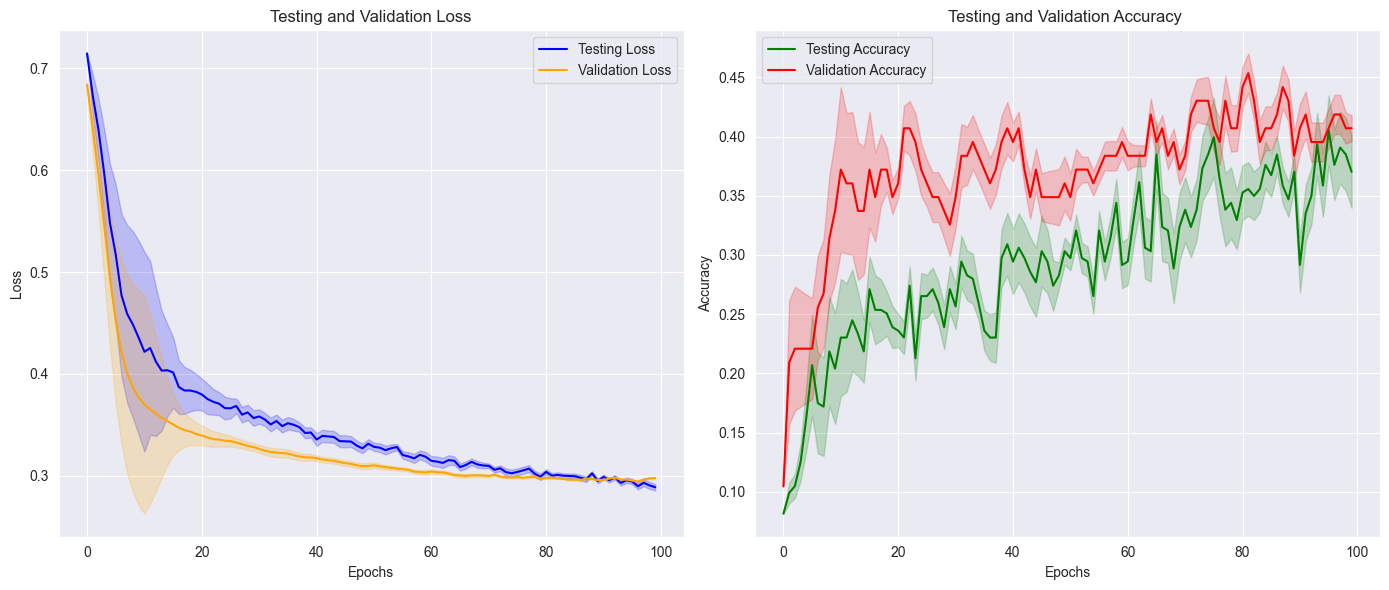

In [20]:

# Assuming you have a Keras 'history' object from training your model
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Convert lists into NumPy arrays for easier manipulation
loss = np.array(loss)
val_loss = np.array(val_loss)
accuracy = np.array(accuracy)
val_accuracy = np.array(val_accuracy)

# Define a window size for rolling calculations (you can adjust this value)
window_size = 10

# Calculate rolling standard deviation for each metric
rolling_std_loss = np.array([np.std(loss[max(0, i - window_size):i+1]) for i in range(len(loss))])
rolling_std_val_loss = np.array([np.std(val_loss[max(0, i - window_size):i+1]) for i in range(len(val_loss))])
rolling_std_accuracy = np.array([np.std(accuracy[max(0, i - window_size):i+1]) for i in range(len(accuracy))])
rolling_std_val_accuracy = np.array([np.std(val_accuracy[max(0, i - window_size):i+1]) for i in range(len(val_accuracy))])

# Plotting Loss vs. Epochs with Error Bars
plt.figure(figsize=(14, 6))

# Plot Loss with Error Bars
plt.subplot(1, 2, 1)
plt.plot(loss, label='Testing Loss', color='blue')
plt.fill_between(range(len(loss)), loss - rolling_std_loss, loss + rolling_std_loss, color='blue', alpha=0.2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.fill_between(range(len(val_loss)), val_loss - rolling_std_val_loss, val_loss + rolling_std_val_loss, color='orange', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing and Validation Loss')
plt.legend()

# Plot Accuracy with Error Bars
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Testing Accuracy', color='green')
plt.fill_between(range(len(accuracy)), accuracy - rolling_std_accuracy, accuracy + rolling_std_accuracy, color='green', alpha=0.2)
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.fill_between(range(len(val_accuracy)), val_accuracy - rolling_std_val_accuracy, val_accuracy + rolling_std_val_accuracy, color='red', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Testing and Validation Accuracy ')
plt.legend()

plt.tight_layout()
plt.show()
